In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

from foods.dashboard import read_database, find_item, make_data, meal_plots, nuts_plots

%load_ext autoreload
%autoreload 2

In [35]:
new_foods = {
    'almond butter': ['pip & nut almont butter', 'added', 54, 7.5, 4.6, np.nan , 27],
    'macadamias': ['macadamia nuts', 'added', 75.3, 6.2, 3.8, 6.3, 9.0],
}
cols = foods.columns
new_foods_df = pd.DataFrame(new_foods.values(), columns=cols)

foods = read_database()
foods = foods.append(new_foods_df, ignore_index=True)

find_item('maca', foods)

,ingredient,category,fat,carbs,sugar,fiber,protein
223,coco macaroon,sweets/cookies/biscuits,40.1,35.8,35.8,12.7,7.1
406,hazelnut macaroon,sweets/cookies/biscuits,37.0,35.5,33.8,6.0,12.2
472,"macaroni from the alps, prepared",prepared dishes/other savoury dishes,9.0,18.6,1.4,1.7,6.0
1019,macadamia nuts,added,75.3,6.2,3.8,6.3,9.0


**Goal**: Be below 13g of carbs so I got room for carbs from broth/bouillon and spirulina.

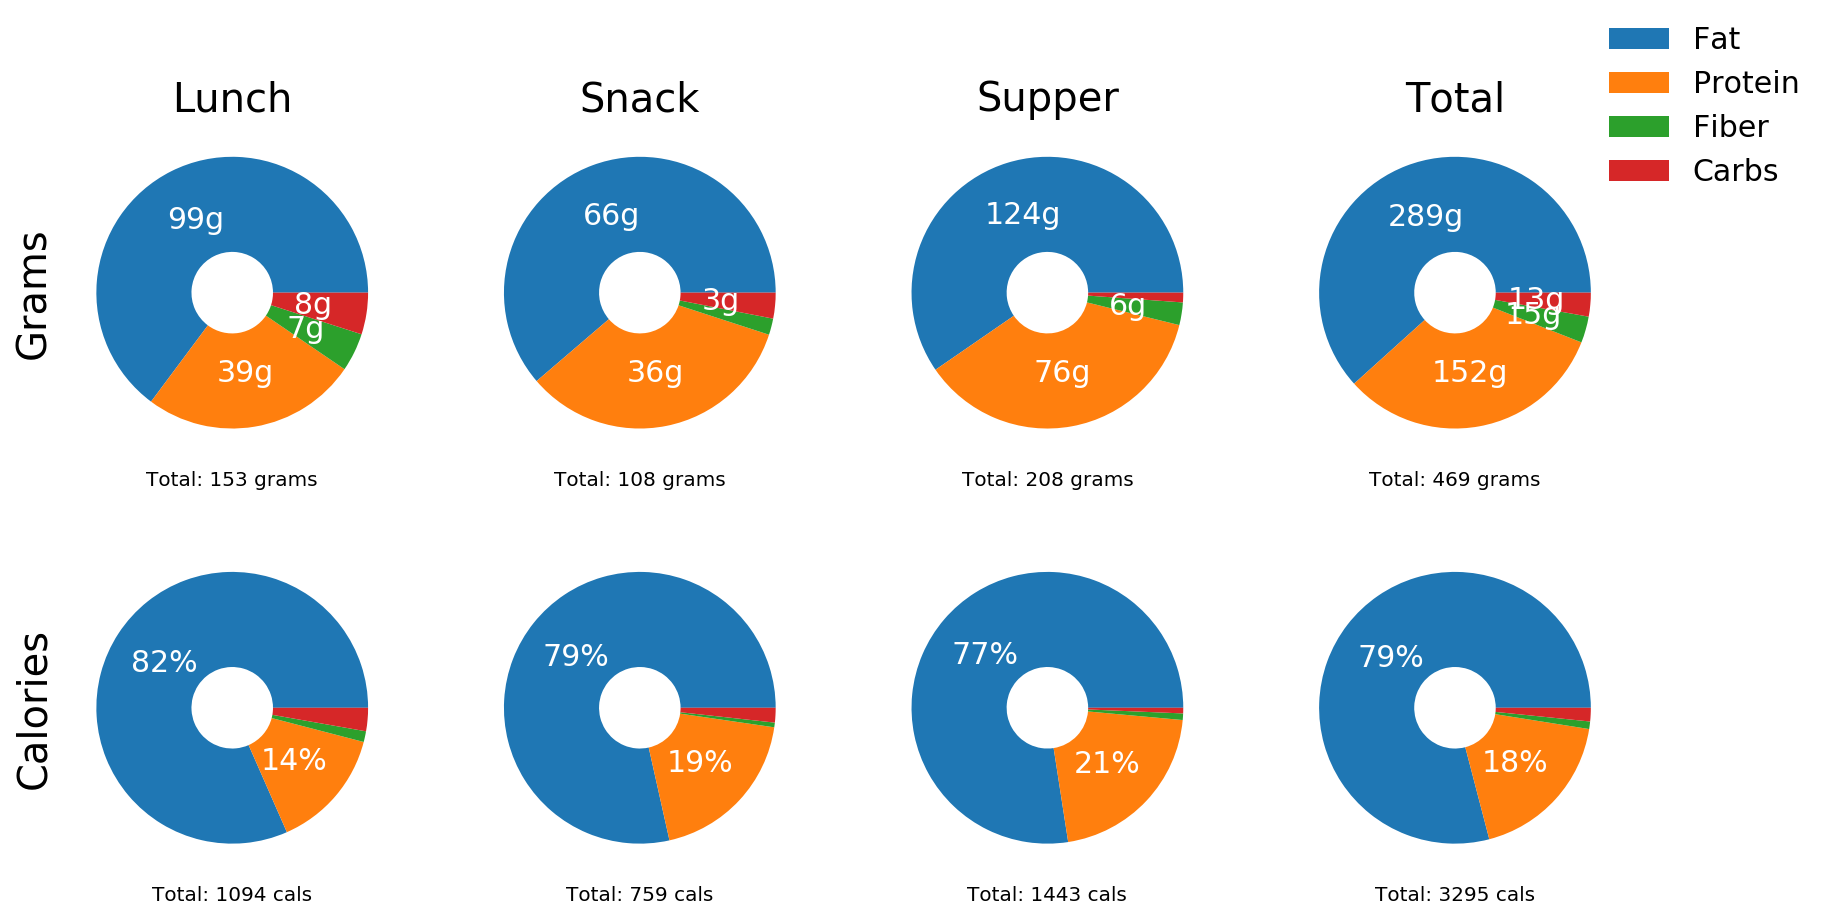

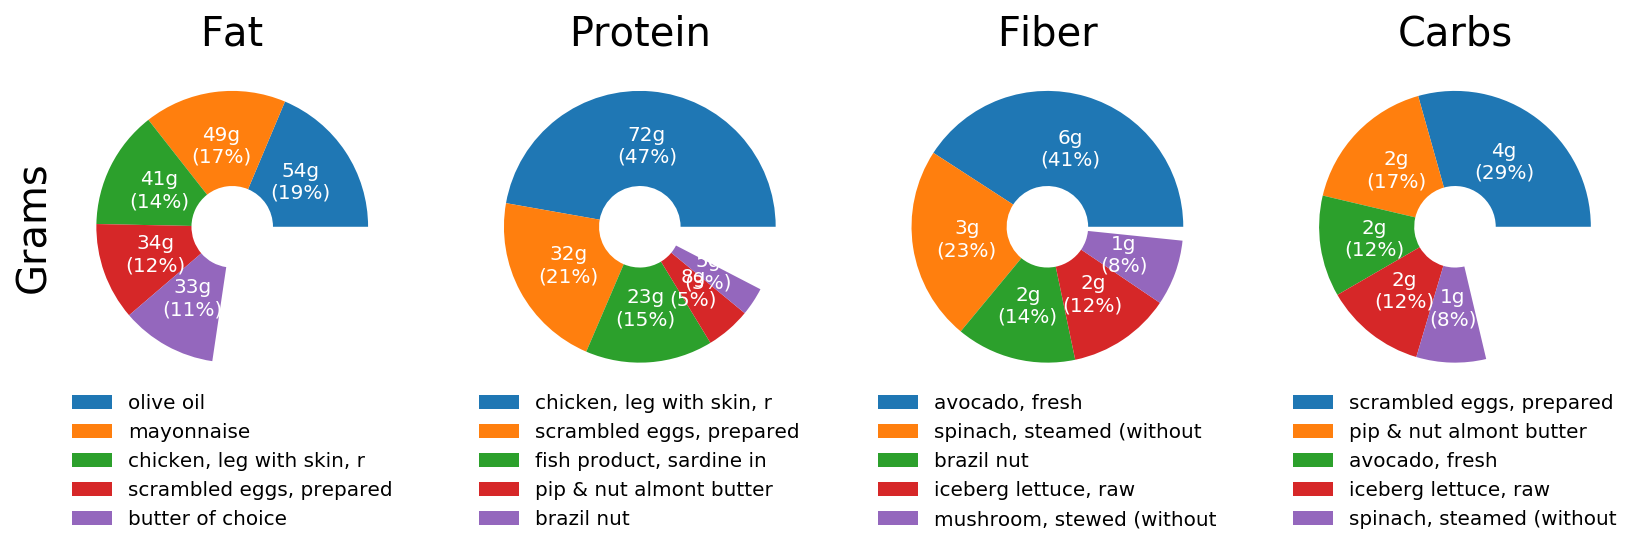

In [32]:
from foods.meals import molly_meals, fabian_meals

meal_data = make_data(fabian_meals, foods)
meal_plots(meal_data)
nuts_plots(meal_data)